## Setup



In [ ]:
# Import packages
import sys
sys.path.append('/content/drive/My Drive/onnx-example-main')
import importlib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import onnxruntime as rt
import onnx
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import to_onnx
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
from skl2onnx import convert_sklearn

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
import random
import math
import seaborn as sns
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.sklearn.detectors import bias_scan

import matplotlib.pyplot as plt


/usr/local/lib/python3.10/dist-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


In [ ]:
# Import local files
import utils.tests_custom as tests
from utils.tests_custom import Tests

In [ ]:
# Define a tester for calling tests later
importlib.reload(tests)
tester = Tests()

# Testing algorithm


In [ ]:
def intoBinary(data, attribute, split):
    sorted_data = data.sort_values(by=attribute)
    split_index = int(len(sorted_data) * split)

    split_threshold = sorted_data.iloc[split_index][attribute]
    print("boundary", split_threshold)
    binary_attribute = pd.Series(0, index=data.index)
    binary_attribute[sorted_data[attribute] > split_threshold] = 1

    data[attribute] = binary_attribute
    return data

In [ ]:
def test_model(pipe, x_training, y_training, x_testing, y_testing, accuracy=True, roc_auc=True, f1=True,
               precision=True, recall=True, conf_matrix=True, cross_validate=False, roc_curves=True,
               dis_imp=True, ba_rat=True, consist=True, mean_diff=True, num_neg=True, rich=True, e_d_f=True, s_p_d=True, detector=False):
  print("Training the model")
  pipe.fit(x_training, y_training)
  y_pred = pipeline.predict(x_testing)

  data_frame = pd.concat([x_testing.reset_index(drop=True), pd.DataFrame(y_pred, columns=['checked'])], axis=1)

  ####
  # Alter this code manually to check for certain data groups have algorithmic bias.
  # Continous features have to be made binary by creating a precentile boundary
  ####

  #In order to seperate continious data into privelidge and unprivalidge, use this call to make it binary
  # data_frame = intoBinary(data_frame, 'persoonlijke_eigenschappen_dagen_sinds_taaleis', 0.2) #This line turns it all binary
  data_frame = intoBinary(data_frame, 'persoon_leeftijd_bij_onderzoek', 0.1)
  ##Manually define what is privelaged and which are not


  # privileged_groups = [{'persoon_geslacht_vrouw': 0}]  # Privileged group for 'persoon_geslacht_vrouw'
  # unprivileged_groups = [{'persoon_geslacht_vrouw': 1}]  # Unprivileged group for 'persoon_geslacht_vrouw'
  # privileged_groups = [{'persoonlijke_eigenschappen_nl_spreken1': 1}]  # Privileged group for 'persoon_geslacht_vrouw'
  # unprivileged_groups = [{'persoonlijke_eigenschappen_nl_spreken1': 0}]  # Unprivileged group for 'persoon_geslacht_vrouw'

  # privileged_groups.append({'persoonlijke_eigenschappen_dagen_sinds_taaleis': 0})
  # unprivileged_groups.append({'persoonlijke_eigenschappen_dagen_sinds_taaleis': 1})
  privileged_groups = [{'persoon_leeftijd_bij_onderzoek': 1}]
  unprivileged_groups = [{'persoon_leeftijd_bij_onderzoek': 0}]
  # privileged_groups = [{'typering_hist_inburgeringsbehoeftig': 0}]
  # unprivileged_groups = [{'typering_hist_inburgeringsbehoeftig': 1}]
  # privileged_groups = [{'instrument_ladder_huidig_werk_re_integratie': 0}]
  # unprivileged_groups = [{'instrument_ladder_huidig_werk_re_integratie': 1}, {'instrument_ladder_huidig_werk_re_integratie': 1}]

  # privileged_groups = [{'persoonlijke_eigenschappen_dagen_sinds_taaleis': 0, 'persoon_geslacht_vrouw': 0}]
  # unprivileged_groups = [{'persoonlijke_eigenschappen_dagen_sinds_taaleis': 1, 'persoon_geslacht_vrouw': 1},
  #  {'persoon_geslacht_vrouw': 1}, {'persoonlijke_eigenschappen_dagen_sinds_taaleis': 1}]


  bld = BinaryLabelDataset(df=data_frame,
                  favorable_label=0,
                  unfavorable_label=1,
                  label_names=['checked'],
                  # unprivileged_protected_attributes=[[1], [1]], #potential change
                  # privileged_protected_attributes=[[0], [0]], #potential change
                  # protected_attribute_names=['persoon_geslacht_vrouw', 'persoonlijke_eigenschappen_dagen_sinds_taaleis'], #potential change
                  unprivileged_protected_attributes=[[0]], #potential change
                  privileged_protected_attributes=[[1]], #potential change
                  protected_attribute_names=['persoon_leeftijd_bij_onderzoek']#'persoon_geslacht_vrouw', 'persoonlijke_eigenschappen_dagen_sinds_taaleis'], #potential change
          )

  # Alter no further than here
  #######

  bld.validate_dataset()
  print(bld.protected_attribute_names)
  stats_table = []
  metric = BinaryLabelDatasetMetric(bld, privileged_groups=privileged_groups, unprivileged_groups=unprivileged_groups)

  if(dis_imp):
    disparate_impact = metric.disparate_impact()
    print("Disparate Impact:", disparate_impact)
    stats_table.append(["Disparate impact", disparate_impact])

  if(ba_rat):
    base_rate = metric.base_rate()
    print("Base Rate:", base_rate)
    stats_table.append(["Base Rate", base_rate])

  if(consist):
    consistency = metric.consistency(n_neighbors=3)
    print("Consistency:", consistency)
    # stats_table.append(["Consistency", consistency])

  if(mean_diff):
    mean_difference = metric.mean_difference()
    print("Mean Difference:", mean_difference)
    stats_table.append(["Mean Difference", mean_difference])

  if(num_neg):
    num_negatives = metric.num_negatives(privileged=None)
    print("Number of Negatives:", num_negatives)
    stats_table.append(["Number of Negatives", num_negatives])

  if(e_d_f):
    emp_diff_fair = metric.smoothed_empirical_differential_fairness(concentration=1.0)
    print("Smoothed Empirical Differential Fairness:", emp_diff_fair)
    stats_table.append(["Smoothed Empirical Differential Fairness", emp_diff_fair])

  if(s_p_d):
    stat_par_diff = metric.statistical_parity_difference()
    print("Statistical Parity Difference:", stat_par_diff)
    stats_table.append(["Statistical Parity Difference", stat_par_diff])

  if(rich):
    rich_subgroup = metric.rich_subgroup(tuple(y_pred))
    print("Rich Subgroup:", rich_subgroup)
    stats_table.append(["Rich Subgroup", rich_subgroup])



  if accuracy:
      acc = accuracy_score(y_testing, y_pred)
      print(f'Accuracy:  {acc}')
      stats_table.append(["Accuracy", acc])

  # ROC AUC
  if roc_auc:
      roc_auc_value = roc_auc_score(y_testing, pipeline.predict_proba(x_testing)[:, 1])
      print(f'ROC AUC:   {roc_auc_value}')
      stats_table.append(["ROC AUC", roc_auc_value])

  # F1 Score
  if f1:
      f1_value = f1_score(y_testing, y_pred)
      print(f'F1 Score:  {f1_value}')
      stats_table.append(["F1 Score", f1_value])

  # Precision
  if precision:
      precision_value = precision_score(y_testing, y_pred)
      print(f'Precision: {precision_value}')
      stats_table.append(["Precision", precision_value])

  # Recall
  if recall:
      recall_value = recall_score(y_testing, y_pred)
      print(f'Recall:    {recall_value}')
      stats_table.append(["Recall", recall_value])

  # Confusion Matrix
  if conf_matrix:
      print('Confusion Matrix:')
      cm = confusion_matrix(y_testing, y_pred)
      print(cm)
      # stats_table.append(["Confusion Matrix", cm])

  # Cross-Validation Scores
  if cross_validate:
      cv_scores = cross_val_score(pipeline, X, y, cv=5)
      print("Cross-Validation Scores:", cv_scores)
      # stats_table.append(["Cross-Validation Scores", cv_scores])

  if detector:
    subset, score = bias_scan(x_testing, y_testing, pd.DataFrame(y_pred), mode='binary')
    print(score)
    print(subset)

  if(roc_curves):
    y_scores = pipeline.predict_proba(x_testing)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_testing, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
  return stats_table


  stats_table = test_model(pipeline, X_train, y_train, X_test, y_test)


# Loading Data & Preprocessing

In [ ]:
# Let's load the dataset
csv_path = '/content/drive/My Drive/onnx-example-main/data/synth_data_for_training.csv' # Your personal drive pathing
data = pd.read_csv(csv_path)

# Let's specify the features and the target
y = data['checked']
X = data.drop(['checked'], axis=1)
X = X.astype(np.float32)

# Let's split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
X_train, y_train = augment(X_train, y_train)

In [ ]:
# Load augmented dataset
train_csv_path = '/content/drive/My Drive/onnx-example-main/data/goodTrain.csv'
test_csv_path = '/content/drive/My Drive/onnx-example-main/data/goodTest.csv'

train = pd.read_csv(train_csv_path)
y_train = train['checked']
X_train = train.drop(['checked'], axis=1)
test = pd.read_csv(test_csv_path)
y_test = test['checked']
X_test = test.drop(['checked'], axis=1)

In [ ]:
# This is just proof of concept I can change the dataset, no real important features selected here
# print(X.iloc[0])
# print(len(X))

# filtered_data_X = X[(X['adres_aantal_brp_adres'] != 6) & (X['adres_dagen_op_adres'] < 100)]
# filtered_data_y = y[X.index.isin(filtered_data_X.index)]
# X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(filtered_data_X, filtered_data_y, test_size=0.25, random_state=42)
# print(len(filtered_data_X))
# print(len(filtered_data_y))

In [ ]:
# Select data based on variance (not the final version yet, for now just for testing)
selector = VarianceThreshold()

In [ ]:
## UNCOMMENT YOUR DESIRED CLASSIFIER

# Gradient Boosting
classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

# Small Neural Network
# classifier = MLPClassifier(hidden_layer_sizes=(512,256,128), activation='relu', warm_start=True, solver='adam', max_iter=200, random_state=0)

# Decision Tree
# classifier = DecisionTreeClassifier(random_state=0)

# Gaussian classification
# classifier = GaussianProcessClassifier(random_state=0, n_jobs=-1)


In [ ]:
#Features to pass (Deemed the dropped features to subjective)

features_to_pass = data.columns.tolist()
print(len(features_to_pass))

features_to_delete = ['competentie_vakdeskundigheid_toepassen', 'pla_historie_ontwikkeling', 'afspraak_inspanningsperiode',
                     'afspraak_laatstejaar_aantal_woorden', 'afspraak_aantal_woorden', 'afspraak_signaal_voor_medewerker',
                     'persoonlijke_eigenschappen_uitstroom_verw_vlgs_klant', 'persoonlijke_eigenschappen_taaleis_voldaan',
                    'competentie_kwaliteit_leveren', 'competentie_gedrevenheid_en_ambitie_tonen',
                     'persoonlijke_eigenschappen_opstelling', 'competentie_overtuigen_en_beïnvloeden', 'competentie_aansturen',
                     'competentie_other', 'competentie_op_de_behoeften_en_verwachtingen_van_de__klant__richten', 'persoonlijke_eigenschappen_houding_opm',
                     'competentie_materialen_en_middelen_inzetten', 'persoonlijke_eigenschappen_leergierigheid_opm', 'competentie_formuleren_en_rapporteren',
                     'persoonlijke_eigenschappen_initiatief_opm', 'competentie_onderzoeken', 'persoonlijke_eigenschappen_presentatie_opm',
                     'competentie_met_druk_en_tegenslag_omgaan', 'persoonlijke_eigenschappen_communicatie_opm', 'persoonlijke_eigenschappen_doorzettingsvermogen_opm',
                     'competentie_instructies_en_procedures_opvolgen', 'competentie_leren', 'competentie_omgaan_met_verandering_en_aanpassen',
                     'persoonlijke_eigenschappen_flexibiliteit_opm', 'persoonlijke_eigenschappen_zelfstandigheid_opm', 'checked']
print(len(features_to_delete))
#elements of features_to_delete but not of features_to_pass
print(([x for x in features_to_delete if x not in features_to_pass]))
print(len(features_to_pass) - len(features_to_delete))
features_to_pass = [x for x in features_to_pass if x not in features_to_delete]
print(len(features_to_pass))


316
31
[]
285
285


In [ ]:
#create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("binned",  KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform'), ['persoon_leeftijd_bij_onderzoek']),
        ('passthrough', 'passthrough', features_to_pass)
    ],
    remainder='drop',
    verbose_feature_names_out=False  # Set verbose_feature_names to False
)

In [ ]:
# Create a pipeline object with our selector and classifier
# NOTE: You can create custom pipeline objects but they must be registered to onnx or it will not recognise them
# Because of this we recommend using the onnx known objects as defined in the documentation
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('standardization', standardizer), ('classification', classifier)])

In [ ]:
#Test to see if pipeline model yields the same as ONNX
#PIPELINE
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
original_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of the original model: ', original_accuracy)
print(len(pipeline.named_steps['preprocessor'].transformers_[1][2]))
# ONNX MODEL

def convert_dataframe_schema(df, drop=None):
    inputs = []
    for k, v in zip(df.columns, df.dtypes):
        if drop is not None and k in drop:
            continue

        t = FloatTensorType([None, 1])

        inputs.append((k, t))
    return inputs

initial_inputs = convert_dataframe_schema(X)
onnx_model = convert_sklearn(
    pipeline, initial_types=initial_inputs,
    target_opset=12)

inputs = {c: X_test[c].values for c in X_test.columns}
for (c, _) in initial_inputs:
    inputs[c] = inputs[c].astype(np.float32)
for k in inputs:
    inputs[k] = inputs[k].reshape((inputs[k].shape[0], 1))

# Let's check the accuracy of the converted model
sess = rt.InferenceSession(onnx_model.SerializeToString())
#inputs = {c: X_test[c].values for c in X_test.columns}
y_pred_onnx =  sess.run(None, inputs)

accuracy_onnx_model = accuracy_score(y_test, y_pred_onnx[0])
print('Accuracy of the ONNX model: ', accuracy_onnx_model)

Accuracy of the original model:  0.9313725490196079
314
Accuracy of the ONNX model:  0.9313725490196079


In [ ]:
# Let's save the model
onnx.save(onnx_model, "/content/drive/My Drive/onnx-example-main/model_1.onnx")

# Let's load the model
#new_session = rt.InferenceSession("model_1.onnx")

# Training & Evaluation

# Local training algorithm

In [ ]:
# Filter the data
# filtered_data = data[ (data['persoonlijke_eigenschappen_dagen_sinds_taaleis'] < 10000)]
filtered_data = data
# filtered_data = filtered_data['persoon_geslacht_vrouw'] = not data['persoon_geslacht_vrouw']
# filtered_data = data[(data['adres_dagen_op_adres'] > 5)]
print()
# Separate features and target
filtered_data_y = filtered_data['checked']
filtered_data_X = filtered_data.drop(['checked'], axis=1)

# Reset index to ensure proper alignment
filtered_data_X.reset_index(drop=True, inplace=True)
filtered_data_y.reset_index(drop=True, inplace=True)

# Convert features to float32 if needed
filtered_data_X = filtered_data_X.astype(np.float32)
filtered_data_X = filtered_data_X.fillna(0)
print(X_train.shape)
print(X_train_filtered.shape)
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(filtered_data_X, filtered_data_y, test_size=0.25, random_state=42)



(19372, 315)
(9483, 315)


Training the model
boundary 35.0
['persoon_leeftijd_bij_onderzoek']
Disparate Impact: 0.9151096231972555
Base Rate: 0.9237824161922834
Consistency: [0.90839131]
Mean Difference: -0.07909764620136128
Number of Negatives: 241.0
Smoothed Empirical Differential Fairness: 0.7749433431114534
Statistical Parity Difference: -0.07909764620136128
Rich Subgroup: 0.0
Accuracy:  0.9313725490196079
ROC AUC:   0.9283162611449809
F1 Score:  0.6032906764168189
Precision: 0.6846473029045643
Recall:    0.5392156862745098
Confusion Matrix:
[[2780   76]
 [ 141  165]]


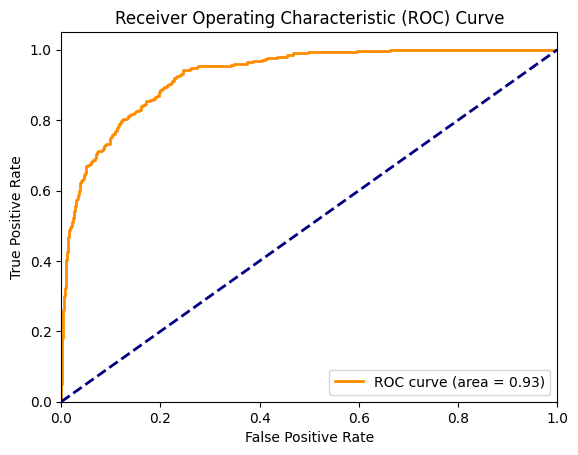

In [ ]:
#stats_table = test_model(pipeline, X_train_filtered, y_train_filtered, X_test_filtered, y_test_filtered)
stats_table = test_model(pipeline, X_train, y_train, X_test, y_test)

In [ ]:
def generate_latex_table(data, name):
    latex_code = "\\begin{table}[htbp]\n"
    latex_code += "    \\centering\n"
    latex_code += "    \\begin{tabular}{|c|c|}\n"
    latex_code += "        \\hline\n"
    latex_code += "        Metric & Score \\\\\n"
    latex_code += "        \\hline\n"

    for entry in data:
        # Format the entry to have three digits after the decimal point
        formatted_entry = "{:.3f}".format(entry[1])
        # Add the formatted entry to the LaTeX code
        latex_code += "        {} & {} \\\\\n".format(entry[0], formatted_entry)

    latex_code += "        \\hline\n"
    latex_code += "    \\end{tabular}\n"
    # Incorporate the table name into the caption
    latex_code += "    \\caption{" + name + "}\n"
    latex_code += "    \\label{tab:" + name.lower().replace(" ", "_") + "}\n"
    latex_code += "\\end{table}\n"

    return latex_code


print(generate_latex_table(stats_table, "Foreign woman"))

\begin{table}[htbp]
    \centering
    \begin{tabular}{|c|c|}
        \hline
        Metric & Score \\
        \hline
        Disparate impact & 0.827 \\
        Base Rate & 0.923 \\
        Mean Difference & -0.162 \\
        Number of Negatives & 242.000 \\
        Smoothed Empirical Differential Fairness & 1.310 \\
        Statistical Parity Difference & -0.162 \\
        Rich Subgroup & 0.000 \\
        Accuracy & 0.946 \\
        ROC AUC & 0.967 \\
        F1 Score & 0.686 \\
        Precision & 0.777 \\
        Recall & 0.614 \\
        \hline
    \end{tabular}
    \caption{Foreign woman}
    \label{tab:foreign_woman}
\end{table}



## Simple Training Pipeline

In [ ]:
# Let's train a simple model
pipeline.fit(X_train, y_train)
# classifier.fit(X_train, y_train)

# Let's evaluate the model
y_pred = pipeline.predict(X_test)

# For Gaussian classifier
# score = classifier.score(X_test, y_test)
# print('Score', score)
# y_pred = classifier.predict(X_test)
# prob = classifier.predict_proba(X_test)
# print('Probabilities', prob)

original_accuracy = accuracy_score(y_test, y_pred)
print('Original accuracy', original_accuracy)

NameError: name 'pipeline' is not defined

Training the model
Accuracy:  0.9313725490196079
roc_auc:   0.9283162611449809
f1:        0.6032906764168189
precision: 0.6846473029045643
recall:    0.5392156862745098
confusion matrix:
[[2780   76]
 [ 141  165]]


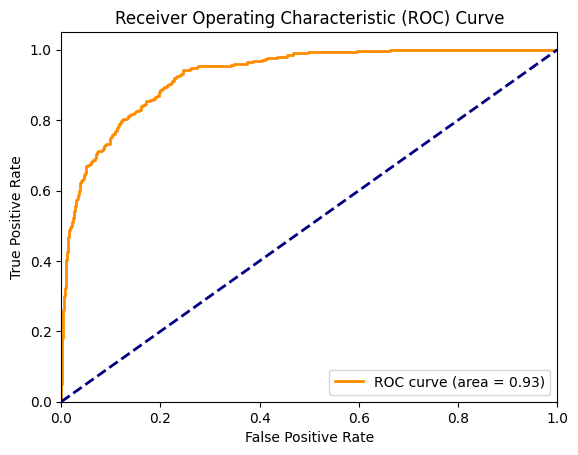

In [ ]:
# More extensive evaluation
tester.testModel(pipeline, X_train, y_train, X_test, y_test)

In [ ]:
# Perform different tests by calling tester.testFunc()
# Available are testDrop, testManWoman, testModel, testNoise, testAlmostZero
# You can implement more tests in the file 'tests_custom'
tester.testDrop(pipeline, data, n_columns=200)

RUN 1: Accuracy with 200 column(s) dropped: 0.9156
RUN 1: Produces zero almost everywhere: False
RUN 2: Accuracy with 200 column(s) dropped: 0.9279
RUN 2: Produces zero almost everywhere: False
RUN 3: Accuracy with 200 column(s) dropped: 0.9171
RUN 3: Produces zero almost everywhere: False
RUN 4: Accuracy with 200 column(s) dropped: 0.9159
RUN 4: Produces zero almost everywhere: False


In [ ]:
tester.testAlmostZero(pipeline, X_test=X_test, y_test=y_test)

False

## Training with Data Modifications


Training the model
Accuracy:  0.9421069281872825
roc_auc:   0.9456787398647865
f1:        0.6500956022944551
precision: 0.7657657657657657
recall:    0.5647840531561462
confusion matrix:
[[2808   52]
 [ 131  170]]


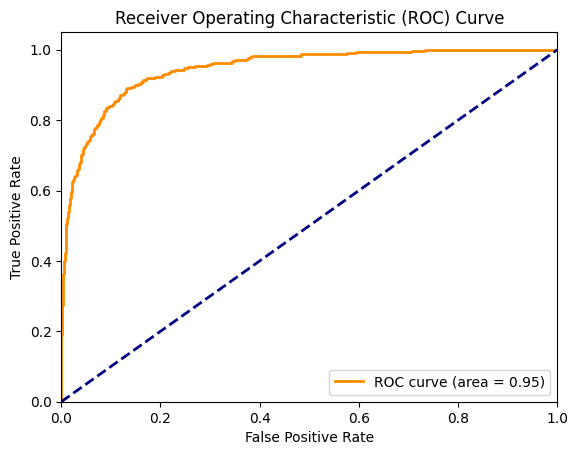

In [ ]:
# Filter the data
filtered_data = data[(data['adres_aantal_brp_adres'] != 6) & (data['adres_dagen_op_adres'] < 1000)]
# filtered_data = data
filtered_data = data[(data['adres_dagen_op_adres'] > 5)]
print()
# Separate features and target
filtered_data_y = filtered_data['checked']
filtered_data_X = filtered_data.drop(['checked'], axis=1)

# Reset index to ensure proper alignment
filtered_data_X.reset_index(drop=True, inplace=True)
filtered_data_y.reset_index(drop=True, inplace=True)

# Convert features to float32 if needed
filtered_data_X = filtered_data_X.astype(np.float32)

X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(filtered_data_X, filtered_data_y, test_size=0.25, random_state=42)

tester.testModel(pipeline, X_train_filtered, y_train_filtered, X_test_filtered, y_test_filtered)

In [ ]:
# Perform different tests by calling tester.testFunc()
# Available are testDrop, testManWoman, testModel, testNoise
# You can implement more tests in the file 'tests_custom'
tester.testModel(pipeline, X_train_filtered, y_train_filtered, X_test_filtered, y_test_filtered)

NameError: name 'pipeline' is not defined

In [ ]:
tester.testManWoman(pipeline, X_test, y_test)

Original Accuracy 0.9493991144845034
12.649110640673518
FLipped Accuracy 0.9506641366223909
7.483314773547883
All Male Accuracy 0.9478178368121443
5.0
All Female Accuracy 0.9522454142947502
5.5677643628300215
All Random Accuracy 0.9509803921568627
5.0


(array([0, 1, 0, ..., 0, 0, 0]),
 array([0, 1, 0, ..., 0, 0, 0]),
 array([0, 1, 0, ..., 0, 0, 0]),
 array([0, 1, 0, ..., 0, 0, 0]),
 array([0, 1, 0, ..., 0, 0, 0]))

# Saving Model as ONNX

In [ ]:
def convert_dataframe_schema(df, drop=None):
    inputs = []
    for k, v in zip(df.columns, df.dtypes):
        if drop is not None and k in drop:
            continue

        t = FloatTensorType([None, 1])

        inputs.append((k, t))
    return inputs

initial_inputs = convert_dataframe_schema(X)


# Let's convert the model to ONNX
onnx_model = convert_sklearn(
    pipeline, initial_types=initial_inputs,
    target_opset=12)

inputs = {c: X_test[c].values for c in X_test.columns}
for (c, _) in initial_inputs:
    inputs[c] = inputs[c].astype(np.float32)
for k in inputs:
    inputs[k] = inputs[k].reshape((inputs[k].shape[0], 1))

# Let's check the accuracy of the converted model
sess = rt.InferenceSession(onnx_model.SerializeToString())
#inputs = {c: X_test[c].values for c in X_test.columns}
y_pred_onnx =  sess.run(None, inputs)

accuracy_onnx_model = accuracy_score(y_test, y_pred_onnx[0])
print('Accuracy of the ONNX model: ', accuracy_onnx_model)

NameError: name 'pipeline' is not defined

In [ ]:
# Let's save the model
onnx_model_path = '/content/drive/My Drive/onnx-example-main/model/gboost.onnx' #Jim's personal drive pathing
onnx.save(onnx_model, onnx_model_path)

# Let's load the model
new_session = rt.InferenceSession(onnx_model_path)

# Let's predict the target
y_pred_onnx2 =  new_session.run(None, {'X': X_test.values.astype(np.float32)})

accuracy_onnx_model = accuracy_score(y_test, y_pred_onnx2[0])
print('Accuracy of the ONNX model: ', accuracy_onnx_model)


Accuracy of the ONNX model:  0.9493991144845034


# Data augmentation

In [ ]:

def get_ngbr(sub_data, knn, dataset, subindex):
    #dataset = sub_data
    rand_sample_id = random.randrange(0, len(sub_data))
    #print(subindex)
    #print(subindex[rand_sample_id])
    #print(Dataset.iloc[rand_sample_id])
    parent = sub_data.iloc[rand_sample_id].to_frame().T
    ngbrs = knn.kneighbors(parent, 2)[1][0]

    parent = dataset.iloc[subindex[rand_sample_id]].to_frame().T
    c1, c2 = dataset.iloc[subindex[ngbrs[0]]], dataset.iloc[subindex[ngbrs[1]]]
    #print(sub_data)
    #parent = dataset.iloc[rand_sample_id]
    return parent, c1, c2

def generate_balanced_dataset(x_train, y_train, p_attrs, cl, targetLabel, targetAttr, ageTransformer=None):
    #print(x_train)
    x_train = x_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    dataset = x_train
    dataset["checked"] = y_train

    if ageTransformer:
        ageTransformer = ageTransformer.fit(x_train)
        X_transformed = ageTransformer.transform(x_train)
        colnames = ageTransformer.get_feature_names_out()
        transformed_dataset = pd.DataFrame(X_transformed, columns=colnames)
    else:
        transformed_dataset = x_train
    transformed_dataset = transformed_dataset.reindex(sorted(transformed_dataset.columns), axis=1)
    transformed_dataset['checked'] = y_train

    standardizer = StandardScaler()
    standardizer = standardizer.fit(transformed_dataset)

    # Count the number of samples in each group
    count_groups = get_count(transformed_dataset, p_attrs, cl, targetLabel, targetAttr)
    #print(count_groups)
    max_size = get_generateMax(transformed_dataset, p_attrs, cl, targetLabel, targetAttr)
    # Params
    cr, f = 0.8, 1.0

    # Iterate over each class label and protected attribute
    for c in cl:
        for attr in p_attrs:
            print("iterating")

            #df.loc[df['column_name'] == some_value]
            #sib = Dataset.loc[Dataset[targetLabel] == some_value]

            sub_data = transformed_dataset[(transformed_dataset[targetLabel] == c) & (transformed_dataset[targetAttr] == attr)]
            subindex = sub_data.index
            sub_group_size = count_groups[(c, attr)]
            to_generate = max_size[c] - sub_group_size
            #print(sub_data)

            #normalizer = Normalizer.fit(sub_data)
            #sub_data = normalizer.transform(sub_data)
            sub_data = pd.DataFrame(standardizer.transform(sub_data), columns=dataset.columns)
            # Apply k-nearest neighbors to find neighbors
            knn = NearestNeighbors().fit(sub_data)

            # Generate new samples to balance the dataset
            for i in range(to_generate):
                parent, c1, c2 = get_ngbr(sub_data, knn, dataset, subindex)
                new_candidate = {}

                for col in dataset.columns:
                    if parent[col].dtype == bool:
                        if cr > random.randrange(0, 1):
                            new_val = random.choice([parent[col], c1[col], c2[col]])
                        else:
                            new_val = parent[col]
                    elif parent[col].dtype == object:  # String
                        new_val = random.choice([parent[col], c1[col], c2[col]])
                    else:  # Numeric
                        if cr > random.randrange(0, 1):
                            #new_val = parent[col] + f * (c1[col] - c2[col])
                            new_val = random.choice([parent[col], c1[col], c2[col]])
                        else:
                            new_val = parent[col]
                    new_candidate[col] = new_val
                    #print(new_candidate)
                #Concat new samples
                dataset = pd.concat([dataset, pd.DataFrame(new_candidate, columns=dataset.columns)], ignore_index=True)

    return dataset


def get_count(Dataset, p_attrs, cl, targetLabel, targetAttr):
    sub_counts = {}

    for i in range(len(cl)):
        for j in range(len(p_attrs)):
            subgrp = Dataset[(Dataset[targetLabel] == cl[i]) & (Dataset[targetAttr] == p_attrs[j])]
            sub_counts[cl[i], p_attrs[j]] = len(subgrp)
    print(sub_counts)
    return sub_counts

def get_ratio(Dataset, cl, targetLabel):

    label_counts = {}
    for i in range(len(cl)):
        label_counts[cl[i]] = len(Dataset[(Dataset[targetLabel] == cl[i])])
    #NoFraud/Fraud
    return label_counts[cl[0]]/label_counts[cl[1]]

def get_generateMax(Dataset, p_attrs, cl, targetLabel, targetAttr):
    ratio = get_ratio(Dataset, cl, targetLabel)
    sub_counts = get_count(Dataset, p_attrs, cl, targetLabel, targetAttr)
    scaled_counts = {}
    limits = {}

    for j in range(len(p_attrs)):
        scaled_counts[cl[0], p_attrs[j]] = sub_counts[cl[0], p_attrs[j]]
        scaled_counts[cl[1], p_attrs[j]] = sub_counts[cl[1], p_attrs[j]]*ratio
    scaledMax = max(scaled_counts.values())


    limits[cl[0]] = int(math.ceil(scaledMax))
    limits[cl[1]] = int(math.ceil(scaledMax/ratio))
    return limits



def drop_features(X):
    return X.drop(columns=['adres_aantal_woonadres_handmatig'])

    preprocessor = ColumnTransformer(
    transformers=[
        #("dropper", droptransformer, ['adres_aantal_woonadres_handmatig']),
        ("binned",  KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform'), ['persoon_leeftijd_bij_onderzoek'])
    ]
    ,remainder='passthrough'  # This means that the remaining columns will be left as they are
)

def augment(X_train, y_train):

    ageTransformer = ColumnTransformer(
        transformers=[

            ("binned",  KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform'), ['persoon_leeftijd_bij_onderzoek'])
        ]
        ,remainder='passthrough'  # This means that the remaining columns will be left as they are
        ,verbose_feature_names_out=False
    )

    #Generate-----------------------------------------------------------------------------------------------------
    cl = [0, 1]
    p_attrs = [0, 1, 2, 3, 4]
    targetLabel = "checked"
    targetAttr = "persoon_leeftijd_bij_onderzoek"
    new_data = generate_balanced_dataset(X_train, y_train, p_attrs, cl, targetLabel, targetAttr, ageTransformer)
    y_train = new_data['checked']
    X_train = new_data.drop(['checked'], axis=1)
    #-------------------------------------------------------------------------------------------------------------
    #Generate-----------------------------------------------------------------------------------------------------
    cl = [0, 1]
    p_attrs = [0, 1]
    targetLabel = "checked"
    targetAttr = "persoon_geslacht_vrouw"
    new_data = generate_balanced_dataset(X_train, y_train, p_attrs, cl, targetLabel, targetAttr)
    y_train = new_data['checked']
    X_train = new_data.drop(['checked'], axis=1)
    #-------------------------------------------------------------------------------------------------------------
    #Generate-----------------------------------------------------------------------------------------------------
    cl = [0, 1]
    p_attrs = [0, 1]
    targetLabel = "checked"
    targetAttr = "persoonlijke_eigenschappen_spreektaal_anders"
    new_data = generate_balanced_dataset(X_train, y_train, p_attrs, cl, targetLabel, targetAttr)
    y_train = new_data['checked']
    X_train = new_data.drop(['checked'], axis=1)
    #-------------------------------------------------------------------------------------------------------------

    return(X_train, y_train)

standardizer = StandardScaler()

In [ ]:
augX_train, augy_train = augment(X_train, y_train)

{(0, 0): 210, (0, 1): 865, (0, 2): 2078, (0, 3): 3255, (0, 4): 2116, (1, 0): 94, (1, 1): 254, (1, 2): 317, (1, 3): 162, (1, 4): 132}
{(0, 0): 210, (0, 1): 865, (0, 2): 2078, (0, 3): 3255, (0, 4): 2116, (1, 0): 94, (1, 1): 254, (1, 2): 317, (1, 3): 162, (1, 4): 132}
iterating
iterating
iterating
iterating
iterating
iterating
iterating
iterating
iterating
iterating
{(0, 0): 8265, (0, 1): 8010, (1, 0): 948, (1, 1): 887}
{(0, 0): 8265, (0, 1): 8010, (1, 0): 948, (1, 1): 887}
iterating
iterating
iterating
iterating
{(0, 0): 8538, (0, 1): 8280, (1, 0): 982, (1, 1): 916}
{(0, 0): 8538, (0, 1): 8280, (1, 0): 982, (1, 1): 916}
iterating
iterating
iterating
iterating


In [ ]:
X_train = augX_train
y_train = augy_train